In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from datetime import datetime, timedelta, date  # Make sure to import date
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
import os
import joblib
from tqdm.auto import tqdm

In [26]:
# ---------- PART 1: DATA LOADING AND PREPROCESSING ----------

def load_ride_data(file_path, ride_name):
    """Load data for a specific ride and perform initial preprocessing."""
    full_data = pd.read_parquet(file_path)
    
    ride_data = full_data.loc[full_data["ride_name"] == ride_name].reset_index(drop=True)
    
    if "closed" in ride_data.columns:
        if ride_data["closed"].dtype == bool:
            ride_data["closed"] = ride_data["closed"].astype(int)
        else:
            ride_data["closed"] = ride_data["closed"].astype(bool).astype(int)
    
    if ride_data['timestamp'].duplicated().any():
        print(f"Warning: Found {ride_data['timestamp'].duplicated().sum()} duplicate timestamps. Keeping first occurrence.")
        ride_data = ride_data[~ride_data['timestamp'].duplicated(keep='first')]
    
    # Check for NaN in wait_time
    if ride_data['wait_time'].isna().sum() > 0:
        print(f"Warning: Found {ride_data['wait_time'].isna().sum()} NaN values in wait_time. Dropping these rows.")
        ride_data = ride_data.dropna(subset=['wait_time'])
    
    try:
        ride_data = ride_data.set_index("timestamp").resample("30min").ffill().reset_index()
    except Exception as e:
        print(f"Error during resampling: {e}")
        print("Using alternative approach to handle resampling...")
        
        ride_data['timestamp_rounded'] = ride_data['timestamp'].dt.floor('30min')
        numeric_cols = ride_data.select_dtypes(include=['number']).columns
        
        non_numeric_cols = [col for col in ride_data.columns 
                           if col not in numeric_cols and col != 'timestamp']

        agg_dict = {col: 'mean' for col in numeric_cols}
        for col in non_numeric_cols:
            agg_dict[col] = 'first'

        ride_data = ride_data.groupby('timestamp_rounded').agg(agg_dict).reset_index()
        ride_data.rename(columns={'timestamp_rounded': 'timestamp'}, inplace=True)

    ride_data = ride_data.loc[ride_data["timestamp"].dt.month > 3].reset_index(drop=True)
    
    # Add date column for easier grouping
    ride_data['date'] = ride_data['timestamp'].dt.date
    
    return ride_data

In [27]:
def remove_closed_and_zero_wait_days(ride_data):
    """Remove days when the ride was fully closed or had no recorded wait times."""
    daily_closure_status = ride_data.groupby(ride_data["timestamp"].dt.date)["closed"].mean()
    fully_closed_days = daily_closure_status[daily_closure_status == 1].index
    
    print(f"Number of fully closed days: {len(fully_closed_days)}")
    print("Sample of fully closed days:", fully_closed_days[:min(10, len(fully_closed_days))])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(fully_closed_days)]

    daily_wait_times = ride_data.groupby(ride_data["timestamp"].dt.date)["wait_time"].mean()
    zero_wait_days = daily_wait_times[daily_wait_times < 1].index
    
    print(f"Number of days with zero wait times: {len(zero_wait_days)}")
    print("Sample of zero wait time days:", zero_wait_days[:min(10, len(zero_wait_days))])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(zero_wait_days)]
    
    return ride_data

In [28]:
def filter_to_operating_hours(ride_data):
    """Keep only data during ride operating hours."""
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()

    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour

    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)

    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])

    def is_operating_hour(timestamp):
        date = timestamp.date()
        if date not in date_to_hours:
            return 0
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data


In [29]:
def extract_daily_attendance_features(ride_data):
    """
    Extract daily attendance features from ride wait time data.
    This creates a dataset for training the attendance prediction model.
    """
    # Ensure date column is datetime type
    ride_data = ride_data.copy()
    if 'date' not in ride_data.columns:
        ride_data['date'] = ride_data['timestamp'].dt.date
    
    # Handle case where date is object type instead of datetime
    if pd.api.types.is_object_dtype(ride_data['date']):
        print("Converting date column to datetime...")
        ride_data['date'] = pd.to_datetime(ride_data['date'])
    
    # Group by date to get daily metrics
    daily_data = ride_data.groupby('date').agg({
        'wait_time': ['mean', 'median', 'max', 'count'],
        'timestamp': 'count',
        'closed': 'mean'
    }).reset_index()
    
    # Flatten column names
    daily_data.columns = ['date'] + [
        f'{col[0]}_{col[1]}' if isinstance(col, tuple) and len(col) > 1 else col[0] 
        for col in daily_data.columns[1:]
    ]
    
    # Rename for clarity
    daily_data = daily_data.rename(columns={
        'wait_time_mean': 'daily_avg_wait',
        'wait_time_median': 'daily_median_wait',
        'wait_time_max': 'daily_max_wait',
        'wait_time_count': 'data_points',
        'timestamp_count': 'operating_hours',
        'closed_mean': 'percent_closed'
    })
    
    # Make sure date is datetime type for feature extraction
    if not pd.api.types.is_datetime64_dtype(daily_data['date']):
        daily_data['date'] = pd.to_datetime(daily_data['date'])
    
    # Create calendar features
    daily_data['year'] = daily_data['date'].dt.year
    daily_data['month'] = daily_data['date'].dt.month
    daily_data['day_of_month'] = daily_data['date'].dt.day
    daily_data['day_of_week'] = daily_data['date'].dt.dayofweek
    daily_data['day_of_year'] = daily_data['date'].dt.dayofyear
    daily_data['is_weekend'] = (daily_data['day_of_week'] >= 5).astype(int)
    
    # Create season
    conditions = [
        (daily_data['month'] >= 3) & (daily_data['month'] <= 5),
        (daily_data['month'] >= 6) & (daily_data['month'] <= 8),
        (daily_data['month'] >= 9) & (daily_data['month'] <= 11),
        (daily_data['month'] == 12) | (daily_data['month'] <= 2)
    ]
    seasons = ['spring', 'summer', 'fall', 'winter']
    daily_data['season'] = np.select(conditions, seasons, default='unknown')
    
    # Create cyclical features
    daily_data['month_sin'] = np.sin(2 * np.pi * daily_data['month'] / 12)
    daily_data['month_cos'] = np.cos(2 * np.pi * daily_data['month'] / 12)
    daily_data['day_of_week_sin'] = np.sin(2 * np.pi * daily_data['day_of_week'] / 7)
    daily_data['day_of_week_cos'] = np.cos(2 * np.pi * daily_data['day_of_week'] / 7)
    daily_data['day_of_year_sin'] = np.sin(2 * np.pi * daily_data['day_of_year'] / 365.25)
    daily_data['day_of_year_cos'] = np.cos(2 * np.pi * daily_data['day_of_year'] / 365.25)
    
    # Create special event/holiday features (if available)
    if 'is_any_holiday' in ride_data.columns:
        holiday_data = ride_data.groupby('date')['is_any_holiday'].max().reset_index()
        daily_data = daily_data.merge(holiday_data, on='date', how='left')
    else:
        daily_data['is_any_holiday'] = 0  # Default value
    
    # Normalize wait times relative to the 95th percentile
    daily_data['attendance_index'] = (
        daily_data['daily_avg_wait'] / daily_data['daily_avg_wait'].quantile(0.95) * 100
    ).clip(upper=100)
    
    return daily_data

In [30]:
def train_attendance_prediction_model(daily_attendance_data, test_year=2023):
    """
    Train a model to predict daily attendance metrics.
    """
    print("Training attendance prediction model...")
    
    # Split data
    train_data = daily_attendance_data[daily_attendance_data['date'].dt.year < test_year]
    test_data = daily_attendance_data[daily_attendance_data['date'].dt.year == test_year]
    
    # Features for attendance prediction
    cat_features = ['season']
    num_features = [
        'month', 'day_of_month', 'day_of_week', 'is_weekend', 
        'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
        'day_of_year_sin', 'day_of_year_cos', 'is_any_holiday'
    ]
    
    # Create preprocessing pipeline
    cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_transformer, cat_features),
            ('num', num_transformer, num_features)
        ]
    )
    
    # Train models for each attendance metric
    models = {}
    metrics = {}
    target_columns = ['daily_avg_wait', 'daily_median_wait', 'daily_max_wait', 'attendance_index']
    
    for target in target_columns:
        print(f"Training model for {target}...")
        
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GradientBoostingRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=3,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42
            ))
        ])
        
        # Check for NaN values
        if train_data[target].isna().sum() > 0:
            print(f"Warning: Found {train_data[target].isna().sum()} NaN values in {target}. Dropping these rows.")
            valid_mask = ~train_data[target].isna()
            X_train = train_data.loc[valid_mask, cat_features + num_features]
            y_train = train_data.loc[valid_mask, target]
        else:
            X_train = train_data[cat_features + num_features]
            y_train = train_data[target]
        
        # Train model
        model.fit(X_train, y_train)
        models[target] = model
        
        # Evaluate on test data
        if len(test_data) > 0:
            X_test = test_data[cat_features + num_features]
            y_test = test_data[target]
            
            y_pred = model.predict(X_test)
            
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            print(f"  Test MAE: {mae:.2f}")
            print(f"  Test RMSE: {rmse:.2f}")
            print(f"  Test R²: {r2:.4f}")
            
            metrics[target] = {
                'mae': mae,
                'rmse': rmse,
                'r2': r2
            }
            
            # Visualize predictions
            plt.figure(figsize=(12, 6))
            plt.plot(test_data['date'], y_test, label='Actual')
            plt.plot(test_data['date'], y_pred, label='Predicted')
            plt.title(f'Attendance Prediction: {target}')
            plt.xlabel('Date')
            plt.ylabel(target)
            plt.legend()
            plt.grid(True, linestyle=':')
            plt.tight_layout()
            plt.show()
    
    attendance_model = {
        'models': models,
        'metrics': metrics,
        'features': {
            'cat_features': cat_features,
            'num_features': num_features
        }
    }
    
    return attendance_model

In [31]:
def predict_attendance(dates, attendance_model, special_events=None):
    """
    Predict attendance metrics for given dates.
    
    Parameters:
    -----------
    dates : list of date or datetime objects
        Dates to predict attendance for
    attendance_model : dict
        Trained attendance prediction model
    special_events : dict, optional
        Dictionary mapping dates to special event flags
        
    Returns:
    --------
    DataFrame with predicted attendance metrics
    """
    # Create feature dataframe
    data = []
    for date_obj in dates:
        # Ensure we're working with date objects
        if isinstance(date_obj, pd.Timestamp):
            date_obj = date_obj.date()
        elif isinstance(date_obj, str):
            date_obj = pd.to_datetime(date_obj).date()
            
        data.append({
            'date': date_obj,
            'year': date_obj.year,
            'month': date_obj.month,
            'day_of_month': date_obj.day,
            'day_of_week': date_obj.weekday(),
            'day_of_year': date_obj.timetuple().tm_yday,
            'is_weekend': 1 if date_obj.weekday() >= 5 else 0,
            # Create season
            'season': (
                'spring' if 3 <= date_obj.month <= 5 else
                'summer' if 6 <= date_obj.month <= 8 else
                'fall' if 9 <= date_obj.month <= 11 else
                'winter'
            ),
            # Cyclical features
            'month_sin': np.sin(2 * np.pi * date_obj.month / 12),
            'month_cos': np.cos(2 * np.pi * date_obj.month / 12),
            'day_of_week_sin': np.sin(2 * np.pi * date_obj.weekday() / 7),
            'day_of_week_cos': np.cos(2 * np.pi * date_obj.weekday() / 7),
            'day_of_year_sin': np.sin(2 * np.pi * date_obj.timetuple().tm_yday / 365.25),
            'day_of_year_cos': np.cos(2 * np.pi * date_obj.timetuple().tm_yday / 365.25),
            'is_any_holiday': 0  # Default value
        })
    
    dates_df = pd.DataFrame(data)
    
    # Convert date column to datetime for consistent handling
    dates_df['date'] = pd.to_datetime(dates_df['date'])
    
    # Add special events if provided
    if special_events is not None:
        for date_obj in dates:
            if date_obj in special_events:
                date_dt = pd.to_datetime(date_obj)
                idx = dates_df.index[dates_df['date'] == date_dt].tolist()
                if idx:
                    dates_df.loc[idx[0], 'is_any_holiday'] = 1
    
    # Get model features
    cat_features = attendance_model['features']['cat_features']
    num_features = attendance_model['features']['num_features']
    
    # Make predictions for each attendance metric
    predictions = {}
    for target, model in attendance_model['models'].items():
        predictions[target] = model.predict(dates_df[cat_features + num_features])
    
    # Create result dataframe
    result = dates_df[['date']].copy()
    for target, preds in predictions.items():
        result[target] = preds
    
    return result

In [32]:
# ---------- PART 3: FEATURE ENGINEERING ----------

def create_binned_time_features(df):
    """Create more granular binned time features and other relevant features."""
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    
    # Create more granular time bins (30-minute bins)
    df['hour_minute'] = df['hour'] + df['minute']/60
    hour_min_bins = [6 + i*0.5 for i in range(37)]  # From 6:00 to 24:00 in 30min intervals
    hour_min_labels = [f"{int(h)}:{int((h-int(h))*60):02d}-{int(h+0.5)}:{int((h+0.5-int(h+0.5))*60):02d}" 
                      for h in hour_min_bins[:-1]]
    
    df['time_30min_bin'] = pd.cut(
        df['hour_minute'], 
        bins=hour_min_bins, 
        labels=hour_min_labels, 
        include_lowest=True, 
        right=False
    )
    
    # Also create 1-hour bins
    hour_bins = list(range(6, 25))
    hour_bin_labels = [f"{h:02d}:00-{h+1:02d}:00" for h in range(6, 24)]
    
    df['hour_bin'] = pd.cut(
        df['hour'], 
        bins=hour_bins, 
        labels=hour_bin_labels, 
        include_lowest=True, 
        right=False
    )
    
    # Time of day bins
    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 9),
        (df['hour'] >= 9) & (df['hour'] < 12),
        (df['hour'] >= 12) & (df['hour'] < 15),
        (df['hour'] >= 15) & (df['hour'] < 18),
        (df['hour'] >= 18) & (df['hour'] < 21),
        (df['hour'] >= 21) | (df['hour'] < 6)
    ]
    
    time_bins = [
        'early_morning',
        'late_morning',
        'early_afternoon',
        'late_afternoon',
        'early_evening',
        'night'
    ]
    
    df['time_of_day_bin'] = np.select(conditions, time_bins, default='other')
    
    # Add day-specific features
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['day_of_month'] = df['timestamp'].dt.day
    df['week_of_year'] = df['timestamp'].dt.isocalendar().week
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    
    # More detailed month and season information
    df['month'] = df['timestamp'].dt.month
    
    # Create month pairs to better capture seasonal effects
    df['month_pair'] = ((df['month'] - 1) // 2) + 1
    
    conditions = [
        (df['month'] >= 3) & (df['month'] <= 5),
        (df['month'] >= 6) & (df['month'] <= 8),
        (df['month'] >= 9) & (df['month'] <= 11),
        (df['month'] == 12) | (df['month'] <= 2)
    ]
    
    seasons = ['spring', 'summer', 'fall', 'winter']
    df['season'] = np.select(conditions, seasons, default='unknown')
    
    # Create interaction features
    df['weekend_hour'] = df['hour'] * df['is_weekend']
    
    # Add day type (weekday vs weekend)
    df['day_type'] = df['day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')
    
    # Add time-of-day combinations
    df['day_time_combo'] = df['day_type'] + '_' + df['time_of_day_bin']
    
    # Even more granular: weekend/weekday + specific hour
    df['day_hour_combo'] = df['day_type'] + '_' + df['hour'].astype(str)
    
    # Process holiday columns
    holiday_cols = ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
    existing_holiday_cols = [col for col in holiday_cols if col in df.columns]
    
    if existing_holiday_cols:
        df['is_any_holiday'] = df[existing_holiday_cols].max(axis=1)
        df['holiday_weekend'] = df['is_any_holiday'] * df['is_weekend']
    else:
        df['is_any_holiday'] = 0
        df['holiday_weekend'] = 0

    # Add cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    
    return df

In [33]:
def enhance_weather_features(df):
    """Create more sophisticated weather features beyond simple temperature and rain."""
    df = df.copy()
    
    # Check if we have weather data
    has_temp = 'temperature' in df.columns
    has_rain = 'rain' in df.columns
    has_wind = 'wind' in df.columns
    
    if not (has_temp or has_rain or has_wind):
        print("No weather data found in the dataframe")
        return df
    
    # Ensure we have date column
    if 'date' not in df.columns:
        df['date'] = df['timestamp'].dt.date
    
    # 1. Create weather change features (rate of change)
    # Group by date to get daily min, max, avg for weather metrics
    weather_daily = df.groupby('date').agg({
        'temperature': ['min', 'max', 'mean', 'std'] if has_temp else 'count',
        'rain': ['max', 'mean', 'sum'] if has_rain else 'count',
        'wind': ['max', 'mean'] if has_wind else 'count'
    })
    
    # Flatten the column names
    weather_daily.columns = ['_'.join(col).strip() for col in weather_daily.columns.values]
    
    # Calculate day-to-day changes
    if has_temp:
        weather_daily['temp_change'] = weather_daily['temperature_mean'].diff()
        weather_daily['temp_range'] = weather_daily['temperature_max'] - weather_daily['temperature_min']
    
    if has_rain:
        # Create a feature for "first rain after dry period"
        weather_daily['was_dry_yesterday'] = (weather_daily['rain_sum'].shift(1) == 0).astype(int)
        weather_daily['first_rain_after_dry'] = (
            (weather_daily['rain_sum'] > 0) & 
            (weather_daily['was_dry_yesterday'] == 1)
        ).astype(int)
    
    # Merge daily weather features back to the main dataframe
    df = df.merge(weather_daily, left_on='date', right_index=True, how='left')
    
    # 2. Create more nuanced temperature features
    if has_temp:
        # Temperature squared for non-linear effects
        df['temperature_squared'] = df['temperature'] ** 2
        
        # Comfort index (simplified version of heat index)
        # People tend to avoid parks when it's too hot or too cold
        df['temp_comfort'] = -((df['temperature'] - 22) ** 2)  # 22°C is assumed optimal
        
        # Binned temperature feel (categorical)
        bins = [-float('inf'), 5, 10, 15, 20, 25, 30, float('inf')]
        labels = ['freezing', 'very_cold', 'cold', 'cool', 'mild', 'warm', 'hot']
        df['temp_feel'] = pd.cut(df['temperature'], bins=bins, labels=labels)
    
    # 3. Create more nuanced rain features
    if has_rain:
        # Rain duration proxy (if we have consecutive hours with rain)
        df['hour'] = df['timestamp'].dt.hour
        df['previous_hour_rain'] = df.groupby('date')['rain'].shift(1).fillna(0)
        df['rain_continued'] = ((df['rain'] > 0) & (df['previous_hour_rain'] > 0)).astype(int)
        
        # Rain intensity categories (more detailed than binary rain/no rain)
        bins = [0, 0.1, 1.0, 2.5, 5.0, float('inf')]
        labels = ['none', 'drizzle', 'light', 'moderate', 'heavy']
        df['rain_intensity'] = pd.cut(df['rain'], bins=bins, labels=labels)
        
        # Binary rain indicator
        df['has_rain'] = (df['rain'] > 0).astype(int)
        
        # Interaction between rain and temperature
        if has_temp:
            # Cold rain is often more uncomfortable than warm rain
            df['cold_rain'] = ((df['temperature'] < 15) & (df['rain'] > 0)).astype(int)
    
    # 4. Create more nuanced wind features
    if has_wind:
        # Wind categories
        bins = [0, 2, 5, 8, 12, float('inf')]
        labels = ['calm', 'light', 'moderate', 'strong', 'extreme']
        df['wind_force'] = pd.cut(df['wind'], bins=bins, labels=labels)
        
        # Create wind and rain interaction
        if has_rain:
            df['rain_with_wind'] = ((df['rain'] > 0) & (df['wind'] > 5)).astype(int)
    
    # 5. Create overall weather comfort score
    weather_factors = []
    
    if has_temp:
        # Temperature factor (0-1 scale, 1 is best)
        df['temp_factor'] = 1.0 - abs(df['temperature'] - 22) / 22
        df['temp_factor'] = df['temp_factor'].clip(0, 1)
        weather_factors.append('temp_factor')
    
    if has_rain:
        # Rain factor (0-1 scale, 1 is best)
        df['rain_factor'] = 1.0 - df['rain'].clip(0, 5) / 5
        weather_factors.append('rain_factor')
    
    if has_wind:
        # Wind factor (0-1 scale, 1 is best)
        df['wind_factor'] = 1.0 - df['wind'].clip(0, 10) / 10
        weather_factors.append('wind_factor')
    
    if len(weather_factors) > 0:
        # Combined weather comfort score (0-100, higher is better)
        df['weather_comfort_score'] = df[weather_factors].mean(axis=1) * 100
    
    return df

In [34]:
def create_special_event_features(df, special_events_dates=None):
    """Add features for special events that might affect park attendance."""
    df = df.copy()
    
    # Ensure we have a date column
    if 'date' not in df.columns:
        df['date'] = df['timestamp'].dt.date
    
    # If no special events are provided, create some default ones
    if special_events_dates is None:
        # Define some approximate special events
        # These are just examples - in practice, you'd use actual dates
        years = df['timestamp'].dt.year.unique()
        
        special_events_dates = {}
        for year in years:
            # Define vacation periods (approximations)
            special_events_dates[f'summer_vacation_{year}'] = [
                pd.to_datetime(f"{year}-07-{day:02d}").date() for day in range(1, 32)
            ] + [
                pd.to_datetime(f"{year}-08-{day:02d}").date() for day in range(1, 32)
            ]
            
            special_events_dates[f'spring_break_{year}'] = [
                pd.to_datetime(f"{year}-04-{day:02d}").date() for day in range(10, 21)
            ]
            
            special_events_dates[f'winter_break_{year}'] = [
                pd.to_datetime(f"{year}-12-{day:02d}").date() for day in range(20, 32)
            ] + [
                pd.to_datetime(f"{year}-01-{day:02d}").date() for day in range(1, 11)
            ]
            
            # Define major holidays
            special_events_dates[f'major_holiday_{year}'] = [
                pd.to_datetime(f"{year}-01-01").date(),  # New Year
                pd.to_datetime(f"{year}-04-14").date(),  # Easter (approximation)
                pd.to_datetime(f"{year}-05-01").date(),  # Labor Day
                pd.to_datetime(f"{year}-12-24").date(),  # Christmas Eve
                pd.to_datetime(f"{year}-12-25").date(),  # Christmas
                pd.to_datetime(f"{year}-12-26").date()   # Boxing Day
            ]
    
    # Create all features at once to avoid fragmentation
    new_feature_data = {}
    
    for event_type, dates in special_events_dates.items():
        feature_name = f'is_{event_type}'
        new_feature_data[feature_name] = df['date'].isin(dates).astype(int)
        
        # Create features for days before and after events
        dates_tomorrow = [date - timedelta(days=1) for date in dates]
        dates_yesterday = [date + timedelta(days=1) for date in dates]
        
        new_feature_data[f'{feature_name}_tomorrow'] = df['date'].isin(dates_tomorrow).astype(int)
        new_feature_data[f'{feature_name}_yesterday'] = df['date'].isin(dates_yesterday).astype(int)
    
    # Add all new features at once to avoid fragmentation
    new_features_df = pd.DataFrame(new_feature_data, index=df.index)
    df = pd.concat([df, new_features_df], axis=1)
    
    # Create a combined 'special_day' feature
    event_columns = [col for col in new_features_df.columns if col.startswith('is_') and 
                     not any(col.endswith(suffix) for suffix in ['_tomorrow', '_yesterday'])]
    
    if event_columns:
        df['is_any_special_event'] = df[event_columns].max(axis=1)
    else:
        df['is_any_special_event'] = 0
    
    return df

In [35]:
def create_predicted_attendance_features(df, attendance_prediction_df):
    """
    Merge predicted attendance features into the main dataframe.
    """
    df = df.copy()
    
    # Ensure we have a date column
    if 'date' not in df.columns:
        df['date'] = df['timestamp'].dt.date
    
    # Convert date objects to datetime if needed
    if not pd.api.types.is_datetime64_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Make sure date in attendance_prediction_df is also datetime
    if not pd.api.types.is_datetime64_dtype(attendance_prediction_df['date']):
        attendance_prediction_df['date'] = pd.to_datetime(attendance_prediction_df['date'])
    
    # Merge attendance predictions
    df = df.merge(attendance_prediction_df, on='date', how='left')
    
    # Fill any missing values (if any dates are missing from predictions)
    attendance_cols = [col for col in attendance_prediction_df.columns if col != 'date']
    for col in attendance_cols:
        if df[col].isna().sum() > 0:
            print(f"Warning: Found {df[col].isna().sum()} missing values in {col}. Filling with median.")
            df[col] = df[col].fillna(df[col].median())
    
    return df

In [36]:
def create_historical_wait_patterns(df):
    """
    Create features based on historical wait time patterns.
    
    Parameters:
    -----------
    df : DataFrame
        Ride data with timestamp and wait_time
        
    Returns:
    --------
    DataFrame with added historical pattern features
    """
    df = df.copy()
    
    # Ensure we have hour and day_of_week columns
    if 'hour' not in df.columns:
        df['hour'] = df['timestamp'].dt.hour
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    # Create hour-based pattern features
    hour_pattern = df.groupby('hour')['wait_time'].agg(['mean', 'median', 'std']).reset_index()
    hour_pattern.columns = ['hour', 'hour_avg_wait', 'hour_median_wait', 'hour_std_wait']
    df = df.merge(hour_pattern, on='hour', how='left')
    
    # Create day-of-week pattern features
    dow_pattern = df.groupby('day_of_week')['wait_time'].agg(['mean', 'median', 'std']).reset_index()
    dow_pattern.columns = ['day_of_week', 'dow_avg_wait', 'dow_median_wait', 'dow_std_wait']
    df = df.merge(dow_pattern, on='day_of_week', how='left')
    
    # Create day-of-week × hour pattern features
    day_hour_pattern = df.groupby(['day_of_week', 'hour'])['wait_time'].mean().reset_index()
    day_hour_pattern.columns = ['day_of_week', 'hour', 'day_hour_avg_wait']
    df = df.merge(day_hour_pattern, on=['day_of_week', 'hour'], how='left')
    
    # Create month × day-of-week pattern features
    if 'month' not in df.columns:
        df['month'] = df['timestamp'].dt.month
    month_day_pattern = df.groupby(['month', 'day_of_week'])['wait_time'].mean().reset_index()
    month_day_pattern.columns = ['month', 'day_of_week', 'month_day_avg_wait']
    df = df.merge(month_day_pattern, on=['month', 'day_of_week'], how='left')
    
    # Create month-day pattern (same day in different years)
    df['month_day'] = df['timestamp'].dt.strftime('%m-%d')
    monthday_pattern = df.groupby('month_day')['wait_time'].mean().reset_index()
    monthday_pattern.columns = ['month_day', 'same_day_avg_wait']
    df = df.merge(monthday_pattern, on='month_day', how='left')
    
    return df

In [37]:
def prepare_features_for_model(df):
    """
    Prepare enhanced features for the model with proper NaN handling.
    
    Parameters:
    -----------
    df : DataFrame
        The preprocessed dataframe with all features
        
    Returns:
    --------
    feature_df : DataFrame
        Features prepared for the model
    categorical_features : list
        Names of categorical features
    numerical_features : list
        Names of numerical features
    """
    print("Starting feature preparation...")
    print(f"Input dataframe shape: {df.shape}")
    
    # First, check for NaN values in the target variable
    if 'wait_time' in df.columns:
        nan_count = df['wait_time'].isna().sum()
        if nan_count > 0:
            print(f"Warning: Found {nan_count} NaN values in wait_time. Dropping these rows.")
            df = df.dropna(subset=['wait_time'])
            print(f"Dataframe shape after dropping NaN wait times: {df.shape}")
    
    # Define categorical and numerical features
    categorical_features = [
        'hour_bin', 
        'time_of_day_bin', 
        'season', 
        'day_of_week', 
        'day_type'
    ]
    
    # Add time bin features if they exist
    if 'time_30min_bin' in df.columns:
        categorical_features.append('time_30min_bin')
    if 'day_time_combo' in df.columns:
        categorical_features.append('day_time_combo')
    if 'day_hour_combo' in df.columns:
        categorical_features.append('day_hour_combo')
    
    # Add weather categorical features if available
    if 'temp_bin' in df.columns:
        categorical_features.append('temp_bin')
    if 'temp_feel' in df.columns:
        categorical_features.append('temp_feel')
    if 'rain_intensity' in df.columns:
        categorical_features.append('rain_intensity')
    if 'wind_force' in df.columns:
        categorical_features.append('wind_force')

    # Define numerical features with base features
    numerical_features = [
        'is_weekend', 
        'hour',
        'day_of_month',
        'week_of_year'
    ]
    
    # Add holiday features if they exist
    if 'is_any_holiday' in df.columns:
        numerical_features.append('is_any_holiday')
    if 'holiday_weekend' in df.columns:
        numerical_features.append('holiday_weekend')
    
    # Add more granular time features if they exist
    if 'minute' in df.columns:
        numerical_features.append('minute')
    if 'hour_minute' in df.columns:
        numerical_features.append('hour_minute')
    
    # Add cyclical features if they exist
    cyclical_features = [
        'day_of_year_sin', 'day_of_year_cos',
        'hour_sin', 'hour_cos',
        'day_of_week_sin', 'day_of_week_cos',
        'month_sin', 'month_cos'
    ]
    for feature in cyclical_features:
        if feature in df.columns:
            numerical_features.append(feature)
    
    # Add interaction features
    if 'weekend_hour' in df.columns:
        numerical_features.append('weekend_hour')
    
    # Add predicted attendance features
    attendance_features = [
        'daily_avg_wait',
        'daily_median_wait',
        'daily_max_wait',
        'attendance_index'
    ]
    for feature in attendance_features:
        if feature in df.columns:
            numerical_features.append(feature)
    
    # Add historical pattern features
    pattern_features = [
        'hour_avg_wait',
        'dow_avg_wait',
        'day_hour_avg_wait',
        'month_day_avg_wait',
        'same_day_avg_wait'
    ]
    for feature in pattern_features:
        if feature in df.columns:
            numerical_features.append(feature)
    
    # Add special event features
    event_features = [col for col in df.columns if col.startswith('is_') and col not in numerical_features]
    for feature in event_features:
        if feature in df.columns:
            numerical_features.append(feature)
    
    # Add weather features if available
    weather_features = [
        'temperature', 'temperature_squared', 'temp_comfort', 'temp_factor',
        'temperature_mean', 'temperature_max', 'temperature_min', 'temp_range',
        'temp_change', 'rain', 'has_rain', 'rain_factor', 'rain_sum', 'rain_mean',
        'rain_max', 'cold_rain', 'wind', 'wind_factor', 'wind_mean', 'wind_max',
        'closed', 'weather_comfort_score'
    ]
    for feature in weather_features:
        if feature in df.columns:
            numerical_features.append(feature)
    
    # Create feature dataframe - only include columns that exist
    all_features = list(set(categorical_features + numerical_features))  # Remove duplicates
    print(f"Total features selected: {len(all_features)}")
    
    # Check if features exist in dataframe
    missing_features = [col for col in all_features if col not in df.columns]
    if missing_features:
        print(f"Warning: These features are missing from the dataframe: {missing_features}")
        all_features = [col for col in all_features if col in df.columns]
    
    feature_df = df[all_features].copy()
    
    # Check for NaN values
    null_counts = feature_df.isnull().sum()
    total_nulls = null_counts.sum()
    
    if total_nulls > 0:
        print(f"Warning: Found {total_nulls} missing values in features")
        
        # Features with the most missing values (top 5)
        print("Features with most missing values:")
        print(null_counts[null_counts > 0].sort_values(ascending=False).head(5))
        
        # Fill missing values in numerical features
        for col in numerical_features:
            if col in feature_df.columns:
                col_null_count = feature_df[col].isnull().sum()
                if col_null_count > 0:
                    print(f"Filling {col_null_count} missing values in '{col}'")
                    feature_df[col] = feature_df[col].fillna(feature_df[col].median())
        
        # Fill missing values in categorical features
        for col in categorical_features:
            if col in feature_df.columns:
                col_null_count = feature_df[col].isnull().sum()
                if col_null_count > 0:
                    print(f"Filling {col_null_count} missing values in '{col}'")
                    mode_value = feature_df[col].mode()
                    if len(mode_value) > 0:
                        feature_df[col] = feature_df[col].fillna(mode_value[0])
                    else:
                        print(f"Warning: Could not find mode for '{col}'. Dropping column.")
                        feature_df = feature_df.drop(columns=[col])
                        if col in categorical_features:
                            categorical_features.remove(col)
    
    # Final check for any remaining NaN values
    remaining_nulls = feature_df.isnull().sum().sum()
    if remaining_nulls > 0:
        print(f"Warning: {remaining_nulls} NaN values remain after filling. Dropping these rows.")
        feature_df = feature_df.dropna()
        print(f"Final feature dataframe shape: {feature_df.shape}")
    
    # Update categorical/numerical features lists to only include columns in the final dataframe
    categorical_features = [col for col in categorical_features if col in feature_df.columns]
    numerical_features = [col for col in numerical_features if col in feature_df.columns]
    
    print(f"Final feature counts: {len(categorical_features)} categorical, {len(numerical_features)} numerical")
    
    return feature_df, categorical_features, numerical_features

In [38]:
# ---------- PART 4: MODELING FUNCTIONS ----------

def build_and_train_nonlinear_model(X_train, y_train, categorical_features, numerical_features):
    """Build and train a model with non-linear transformations of the target variable."""
    # Apply a power transformation to the target variable
    # This helps with the issue of under-predicting high values and over-predicting low values
    pt = PowerTransformer(method='yeo-johnson')
    
    # Add small constant to avoid issues with zero values
    y_train_transformed = pt.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Build the model using the transformed target
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )

    # Use a Ridge regression model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ])

    # Train on the transformed target
    model.fit(X_train, y_train_transformed)
    
    # Return both the model and the transformer for later use
    return model, pt


In [39]:
def build_gradient_boosting_model(X_train, y_train, categorical_features, numerical_features):
    """Build and train a gradient boosting model for wait time prediction."""
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )

    # Use GradientBoostingRegressor which handles non-linearity well
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=4,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])

    model.fit(X_train, y_train)
    return model

In [40]:
def train_ensemble_model(X_train, y_train, categorical_features, numerical_features):
    """Train an ensemble of different models and combine their predictions."""
    # Create preprocessor
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )
    
    # Create preprocessed features once to avoid redundant computation
    X_train_processed = preprocessor.fit_transform(X_train)
    
    # Create multiple base models
    linear_model = Ridge(alpha=1.0)
    rf_model = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    gb_model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    # Train each model
    print("Training linear model...")
    linear_model.fit(X_train_processed, y_train)
    
    print("Training random forest model...")
    rf_model.fit(X_train_processed, y_train)
    
    print("Training gradient boosting model...")
    gb_model.fit(X_train_processed, y_train)
    
    # Create voting ensemble
    ensemble = VotingRegressor([
        ('linear', linear_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ])
    
    print("Training ensemble model...")
    ensemble.fit(X_train_processed, y_train)
    
    # Create a final pipeline that includes preprocessing
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('ensemble', ensemble)
    ])
    
    return final_model, {'linear': linear_model, 'rf': rf_model, 'gb': gb_model, 'ensemble': ensemble}


In [41]:
def build_peak_correction_model(X_train, y_train, y_pred_train, categorical_features, numerical_features):
    """
    Build a secondary model to correct errors in high/low wait time predictions.
    This is especially useful for improving predictions at the extremes.
    """
    # Calculate primary model errors
    errors = y_train - y_pred_train
    
    # Add the primary model's prediction as a feature
    X_train_with_pred = X_train.copy()
    X_train_with_pred['primary_prediction'] = y_pred_train
    
    # Add error indicator features
    X_train_with_pred['is_low_wait'] = (y_pred_train < 10).astype(int)
    X_train_with_pred['is_high_wait'] = (y_pred_train > 40).astype(int)
    
    # Create quartile indicators based on primary prediction
    quartiles = pd.qcut(y_pred_train, 4, labels=False)
    for i in range(4):
        X_train_with_pred[f'quartile_{i}'] = (quartiles == i).astype(int)
    
    # Add the prediction to the numerical features
    numerical_features_with_pred = numerical_features + ['primary_prediction', 'is_low_wait', 'is_high_wait']
    numerical_features_with_pred.extend([f'quartile_{i}' for i in range(4)])
    
    # Build correction model to predict the errors
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features_with_pred)
        ]
    )

    # Use GradientBoostingRegressor for the correction model
    correction_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ))
    ])

    # Train to predict the errors
    correction_model.fit(X_train_with_pred, errors)
    
    return correction_model

In [42]:
def apply_correction_model(primary_model, correction_model, X_test, y_test=None):
    """
    Apply the correction model to improve predictions.
    """
    # Get predictions from primary model
    y_pred_primary = primary_model.predict(X_test)
    
    # Ensure predictions are non-negative
    y_pred_primary = np.maximum(y_pred_primary, 0)
    
    # Create features for correction model
    X_test_with_pred = X_test.copy()
    X_test_with_pred['primary_prediction'] = y_pred_primary
    
    # Add error indicator features
    X_test_with_pred['is_low_wait'] = (y_pred_primary < 10).astype(int)
    X_test_with_pred['is_high_wait'] = (y_pred_primary > 40).astype(int)
    
    # Create quartile indicators based on primary prediction
    quartiles = pd.qcut(y_pred_primary, 4, labels=False)
    for i in range(4):
        X_test_with_pred[f'quartile_{i}'] = (quartiles == i).astype(int)
    
    # Predict the errors
    predicted_errors = correction_model.predict(X_test_with_pred)
    
    # Apply corrections
    y_pred_corrected = y_pred_primary + predicted_errors
    
    # Ensure final predictions are non-negative
    y_pred_corrected = np.maximum(y_pred_corrected, 0)
    
    # Evaluate if y_test is provided
    if y_test is not None:
        # Evaluate primary model
        mae_primary = mean_absolute_error(y_test, y_pred_primary)
        rmse_primary = np.sqrt(mean_squared_error(y_test, y_pred_primary))
        r2_primary = r2_score(y_test, y_pred_primary)
        
        # Calculate MAPE for primary model
        epsilon = 1e-8
        abs_pct_errors_primary = np.abs(y_test - y_pred_primary) / (np.abs(y_test) + epsilon)
        non_zero_mask = y_test > 0
        mape_primary = np.mean(abs_pct_errors_primary[non_zero_mask]) * 100
        
        # Evaluate corrected model
        mae_corrected = mean_absolute_error(y_test, y_pred_corrected)
        rmse_corrected = np.sqrt(mean_squared_error(y_test, y_pred_corrected))
        r2_corrected = r2_score(y_test, y_pred_corrected)
        
        # Calculate MAPE for corrected model
        abs_pct_errors_corrected = np.abs(y_test - y_pred_corrected) / (np.abs(y_test) + epsilon)
        mape_corrected = np.mean(abs_pct_errors_corrected[non_zero_mask]) * 100
        
        print("Primary Model Metrics:")
        print(f"MAE: {mae_primary:.2f}, RMSE: {rmse_primary:.2f}, R²: {r2_primary:.4f}, MAPE: {mape_primary:.2f}%")
        
        print("\nCorrected Model Metrics:")
        print(f"MAE: {mae_corrected:.2f}, RMSE: {rmse_corrected:.2f}, R²: {r2_corrected:.4f}, MAPE: {mape_corrected:.2f}%")
        
        print(f"\nImprovement:")
        print(f"MAE: {mae_primary - mae_corrected:.2f} ({(mae_primary - mae_corrected) / mae_primary * 100:.2f}%)")
        print(f"RMSE: {rmse_primary - rmse_corrected:.2f} ({(rmse_primary - rmse_corrected) / rmse_primary * 100:.2f}%)")
        print(f"R²: {r2_corrected - r2_primary:.4f} ({(r2_corrected - r2_primary) / max(0.0001, abs(r2_primary)) * 100:.2f}%)")
        print(f"MAPE: {mape_primary - mape_corrected:.2f}% ({(mape_primary - mape_corrected) / mape_primary * 100:.2f}%)")
        
        # Compare predictions at different ranges
        low_wait_mask = y_test < 10
        high_wait_mask = y_test > 40
        
        if np.sum(low_wait_mask) > 0:
            mae_low_primary = mean_absolute_error(y_test[low_wait_mask], y_pred_primary[low_wait_mask])
            mae_low_corrected = mean_absolute_error(y_test[low_wait_mask], y_pred_corrected[low_wait_mask])
            print(f"\nLow Wait (<10 min) MAE: {mae_low_primary:.2f} -> {mae_low_corrected:.2f} ({(mae_low_primary - mae_low_corrected) / mae_low_primary * 100:.2f}% improvement)")
        
        if np.sum(high_wait_mask) > 0:
            mae_high_primary = mean_absolute_error(y_test[high_wait_mask], y_pred_primary[high_wait_mask])
            mae_high_corrected = mean_absolute_error(y_test[high_wait_mask], y_pred_corrected[high_wait_mask])
            print(f"High Wait (>40 min) MAE: {mae_high_primary:.2f} -> {mae_high_corrected:.2f} ({(mae_high_primary - mae_high_corrected) / mae_high_primary * 100:.2f}% improvement)")
        
        return y_pred_corrected, {
            'primary': {
                'mae': mae_primary,
                'rmse': rmse_primary,
                'r2': r2_primary,
                'mape': mape_primary
            },
            'corrected': {
                'mae': mae_corrected,
                'rmse': rmse_corrected,
                'r2': r2_corrected,
                'mape': mape_corrected
            }
        }
    
    return y_pred_corrected

In [43]:
def evaluate_model(model, X_test, y_test, feature_names=None, return_predictions=True, transformer=None):
    """Evaluate the model and print coefficients."""
    # Get raw predictions
    y_pred_raw = model.predict(X_test)
    
    # Apply inverse transform if a transformer is provided
    if transformer is not None:
        y_pred_raw = transformer.inverse_transform(y_pred_raw.reshape(-1, 1)).ravel()
    
    # Clip predictions at 0 to prevent negative wait times
    y_pred = np.maximum(y_pred_raw, 0)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
    print(f"R² Score: {r2:.4f}")

    epsilon = 1e-8
    abs_pct_errors = np.abs(y_test - y_pred) / (np.abs(y_test) + epsilon)
    non_zero_mask = y_test > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Evaluate model performance at different wait time ranges
    low_wait_mask = y_test < 10
    medium_wait_mask = (y_test >= 10) & (y_test <= 40)
    high_wait_mask = y_test > 40
    
    if np.sum(low_wait_mask) > 0:
        mae_low = mean_absolute_error(y_test[low_wait_mask], y_pred[low_wait_mask])
        print(f"MAE for low wait times (<10 min): {mae_low:.2f} minutes")
    
    if np.sum(medium_wait_mask) > 0:
        mae_medium = mean_absolute_error(y_test[medium_wait_mask], y_pred[medium_wait_mask])
        print(f"MAE for medium wait times (10-40 min): {mae_medium:.2f} minutes")
    
    if np.sum(high_wait_mask) > 0:
        mae_high = mean_absolute_error(y_test[high_wait_mask], y_pred[high_wait_mask])
        print(f"MAE for high wait times (>40 min): {mae_high:.2f} minutes")

    # Try to extract feature importance if possible
    if feature_names is not None:
        try:
            # For linear models
            if hasattr(model, 'named_steps') and hasattr(model.named_steps['regressor'], 'coef_'):
                preprocessor = model.named_steps['preprocessor']
                regressor = model.named_steps['regressor']
                
                # Get feature names after preprocessing
                try:
                    transformed_feature_names = preprocessor.get_feature_names_out()
                except:
                    # Fallback for older scikit-learn versions
                    transformed_feature_names = []
                    for name, transformer, features in preprocessor.transformers_:
                        if hasattr(transformer, 'get_feature_names_out'):
                            transformed_names = transformer.get_feature_names_out(features)
                            transformed_feature_names.extend(transformed_names)
                        else:
                            transformed_feature_names.extend(features)
                
                coefficients = pd.DataFrame({
                    'Feature': transformed_feature_names,
                    'Coefficient': regressor.coef_
                })
                coefficients = coefficients.sort_values('Coefficient', ascending=False)
                
                print("\nTop 10 Most Important Features:")
                print(coefficients.head(10))
                
                print("\nBottom 10 Features:")
                print(coefficients.tail(10))
            
            # For tree-based models
            elif hasattr(model, 'named_steps') and hasattr(model.named_steps['regressor'], 'feature_importances_'):
                preprocessor = model.named_steps['preprocessor']
                regressor = model.named_steps['regressor']
                
                # Get feature names after preprocessing
                try:
                    transformed_feature_names = preprocessor.get_feature_names_out()
                except:
                    # Fallback for older scikit-learn versions
                    transformed_feature_names = []
                    for name, transformer, features in preprocessor.transformers_:
                        if hasattr(transformer, 'get_feature_names_out'):
                            transformed_names = transformer.get_feature_names_out(features)
                            transformed_feature_names.extend(transformed_names)
                        else:
                            transformed_feature_names.extend(features)
                
                importances = pd.DataFrame({
                    'Feature': transformed_feature_names,
                    'Importance': regressor.feature_importances_
                })
                importances = importances.sort_values('Importance', ascending=False)
                
                print("\nTop 20 Most Important Features:")
                print(importances.head(20))
        except Exception as e:
            print(f"Could not extract feature importance: {e}")
    
    if return_predictions:
        return mae, rmse, r2, mape, y_pred
    else:
        return mae, rmse, r2, mape

In [44]:
def visualize_results(y_test, y_pred, timestamps, title_suffix=""):
    """Visualize the prediction results."""
    # Make sure predictions are non-negative
    y_pred = np.maximum(y_pred, 0)
    
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_pred - y_test,
        'Timestamp': timestamps
    })

    # 1. Scatter plot of Actual vs Predicted
    plt.figure(figsize=(10, 8))
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('Actual Wait Time (minutes)')
    plt.ylabel('Predicted Wait Time (minutes)')
    plt.title(f'Actual vs Predicted Wait Times {title_suffix}')
    plt.grid(True, linestyle=':')

    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

    # 2. Time series plot
    results_df = results_df.sort_values('Timestamp')
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Timestamp'], results_df['Actual'], label='Actual', alpha=0.7)
    plt.plot(results_df['Timestamp'], results_df['Predicted'], label='Predicted', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Wait Time (minutes)')
    plt.title(f'Actual vs Predicted Wait Times Over Time {title_suffix}')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Analyze errors by wait time range
    plt.figure(figsize=(10, 6))
    
    # Create wait time bins
    bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    
    results_df['wait_bin'] = pd.cut(results_df['Actual'], bins=bins, labels=labels)
    
    # Calculate metrics for each bin
    bin_metrics = results_df.groupby('wait_bin').agg({
        'Error': ['mean', 'std'],
        'Actual': 'count'
    })
    
    bin_metrics.columns = ['Mean Error', 'Std Error', 'Count']
    bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())
    
    # Plot mean absolute error by wait time range
    plt.bar(bin_metrics.index, bin_metrics['Abs Mean Error'], alpha=0.7)
    plt.xlabel('Actual Wait Time Range (minutes)')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.title(f'Error by Wait Time Range {title_suffix}')
    
    # Add count labels
    for i, count in enumerate(bin_metrics['Count']):
        plt.text(i, bin_metrics['Abs Mean Error'].iloc[i] + 0.5, f"n={count}", 
                 ha='center', va='bottom', fontsize=8)
    
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()
    
    return results_df


In [45]:
# ---------- PART 5: FULL PIPELINE WITH ATTENDANCE PREDICTION ----------

def train_wait_time_prediction_model(ride_data, test_year=2023, model_type='corrected_gradient_boosting'):
    """
    Full pipeline for training a wait time prediction model with attendance prediction.
    
    Parameters:
    -----------
    ride_data : DataFrame
        The preprocessed ride data
    test_year : int
        Year to use for testing
    model_type : str
        Type of model to train ('linear', 'gradient_boosting', 'corrected_gradient_boosting', 'ensemble')
        
    Returns:
    --------
    Dict containing trained models and evaluation results
    """
    print(f"=== Training wait time prediction model (type: {model_type}) ===")
    
    # Step 1: Create all features
    print("\n----- Step 1: Creating all features -----")
    ride_data = create_binned_time_features(ride_data)
    ride_data = enhance_weather_features(ride_data)
    ride_data = create_special_event_features(ride_data)
    ride_data = create_historical_wait_patterns(ride_data)  # Historical patterns based on training data only
    
    # Step 2: Split data into train/test
    print("\n----- Step 2: Splitting data into train/test -----")
    train_data = ride_data[ride_data['timestamp'].dt.year < test_year].copy()
    test_data = ride_data[ride_data['timestamp'].dt.year == test_year].copy()
    
    print(f"Training data: {len(train_data)} samples")
    print(f"Test data: {len(test_data)} samples")
    
    # Step 3: Train attendance prediction model using only training data
    print("\n----- Step 3: Training attendance prediction model -----")
    daily_attendance_train = extract_daily_attendance_features(train_data)
    attendance_model = train_attendance_prediction_model(daily_attendance_train, test_year)
    
    # Step 4: Predict attendance for test data
    print("\n----- Step 4: Predicting attendance for test data -----")
    test_dates = test_data['date'].unique()
    predicted_attendance_test = predict_attendance(test_dates, attendance_model)
    
    # Step 5: Add predicted attendance to test data
    print("\n----- Step 5: Adding predicted attendance to test data -----")
    test_data = create_predicted_attendance_features(test_data, predicted_attendance_test)
    
    # For training data, we use actual attendance metrics (no prediction)
    train_data = train_data.copy()
    
    # Step 6: Prepare features for modeling
    print("\n----- Step 6: Preparing features for modeling -----")
    X_train, categorical_features, numerical_features = prepare_features_for_model(train_data)
    y_train = train_data['wait_time'].values
    
    X_test, _, _ = prepare_features_for_model(test_data)
    y_test = test_data['wait_time'].values
    
    # Step 7: Train wait time prediction model
    print("\n----- Step 7: Training wait time prediction model -----")
    
    if model_type == 'linear':
        print("Training linear model with non-linear transformation...")
        model, pt = build_and_train_nonlinear_model(X_train, y_train, categorical_features, numerical_features)
        mae, rmse, r2, mape, y_pred = evaluate_model(model, X_test, y_test, transformer=pt)
        
        results = {
            'model': model,
            'transformer': pt,
            'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape},
            'predictions': y_pred,
            'features': {'categorical': categorical_features, 'numerical': numerical_features}
        }
    
    elif model_type == 'gradient_boosting':
        print("Training gradient boosting model...")
        model = build_gradient_boosting_model(X_train, y_train, categorical_features, numerical_features)
        mae, rmse, r2, mape, y_pred = evaluate_model(model, X_test, y_test)
        
        results = {
            'model': model,
            'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape},
            'predictions': y_pred,
            'features': {'categorical': categorical_features, 'numerical': numerical_features}
        }
    
    elif model_type == 'corrected_gradient_boosting':
        print("Training gradient boosting model with peak correction...")
        
        # Train primary model
        primary_model = build_gradient_boosting_model(X_train, y_train, categorical_features, numerical_features)
        
        # Get training predictions for correction model
        y_pred_train = primary_model.predict(X_train)
        
        # Build correction model
        correction_model = build_peak_correction_model(
            X_train, y_train, y_pred_train, categorical_features, numerical_features
        )
        
        # Apply correction to test data
        y_pred_corrected, metrics = apply_correction_model(primary_model, correction_model, X_test, y_test)
        
        results = {
            'primary_model': primary_model,
            'correction_model': correction_model,
            'metrics': metrics,
            'predictions': y_pred_corrected,
            'features': {'categorical': categorical_features, 'numerical': numerical_features}
        }
    
    elif model_type == 'ensemble':
        print("Training ensemble model...")
        model, base_models = train_ensemble_model(X_train, y_train, categorical_features, numerical_features)
        mae, rmse, r2, mape, y_pred = evaluate_model(model, X_test, y_test)
        
        results = {
            'model': model,
            'base_models': base_models,
            'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape},
            'predictions': y_pred,
            'features': {'categorical': categorical_features, 'numerical': numerical_features}
        }
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Step 8: Visualize results
    print("\n----- Step 8: Visualizing results -----")
    visualize_results(y_test, results['predictions'], test_data['timestamp'].values, title_suffix=f"({model_type})")
    
    # Step 9: Save attendance model
    results['attendance_model'] = attendance_model
    
    return results

In [46]:
def predict_future_wait_times(ride_name, future_dates, future_hours, saved_model_path, historical_data_path, special_events_future=None, weather_forecast=None):
    """
    Predict wait times for specific future dates and hours.
    
    Parameters:
    -----------
    ride_name : str
        Name of the ride to predict for
    future_dates : list of datetime.date
        Future dates to predict for
    future_hours : list of int
        Hours to predict for each date
    saved_model_path : str
        Path to the saved model files
    historical_data_path : str
        Path to historical data
    special_events_future : dict, optional
        Dictionary of future special events by date
    weather_forecast : DataFrame, optional
        Weather forecast for future dates
        
    Returns:
    --------
    DataFrame with predicted wait times
    """
    print(f"=== Predicting future wait times for {ride_name} ===")
    
    # Step 1: Load historical data
    print("\n----- Step 1: Loading historical data -----")
    historical_data = pd.read_parquet(historical_data_path)
    historical_data = historical_data[historical_data['ride_name'] == ride_name]
    print(f"Loaded historical data: {len(historical_data)} samples")
    
    # Ensure we have a date column
    if 'date' not in historical_data.columns:
        historical_data['date'] = historical_data['timestamp'].dt.date
    
    # Step 2: Load trained models
    print("\n----- Step 2: Loading trained models -----")
    try:
        # Try to load corrected gradient boosting model
        primary_model = joblib.load(f"{saved_model_path}/{ride_name}_primary_model.joblib")
        correction_model = joblib.load(f"{saved_model_path}/{ride_name}_correction_model.joblib")
        attendance_model = joblib.load(f"{saved_model_path}/{ride_name}_attendance_model.joblib")
        model_type = 'corrected_gradient_boosting'
        print(f"Loaded corrected gradient boosting model for {ride_name}")
    except:
        try:
            # Try to load ensemble model
            model = joblib.load(f"{saved_model_path}/{ride_name}_ensemble_model.joblib")
            attendance_model = joblib.load(f"{saved_model_path}/{ride_name}_attendance_model.joblib")
            model_type = 'ensemble'
            print(f"Loaded ensemble model for {ride_name}")
        except:
            try:
                # Load gradient boosting model
                model = joblib.load(f"{saved_model_path}/{ride_name}_gradient_boosting_model.joblib")
                attendance_model = joblib.load(f"{saved_model_path}/{ride_name}_attendance_model.joblib")
                model_type = 'gradient_boosting'
                print(f"Loaded gradient boosting model for {ride_name}")
            except:
                print(f"Could not load any model for {ride_name}. Please train a model first.")
                return None
    
    # Step 3: Generate feature data for each future date-hour
    print("\n----- Step 3: Generating features for future dates -----")
    
    # First, predict attendance for future dates
    # Make sure dates are converted to standard date objects
    standard_dates = []
    for date_obj in future_dates:
        if isinstance(date_obj, pd.Timestamp):
            standard_dates.append(date_obj.date())
        elif isinstance(date_obj, str):
            standard_dates.append(pd.to_datetime(date_obj).date())
        else:
            standard_dates.append(date_obj)  # Assume it's already a date object
    
    future_attendance = predict_attendance(standard_dates, attendance_model, special_events_future)
    print(f"Predicted attendance for {len(future_attendance)} future dates")
    
    # Create feature rows for each date-hour combination
    feature_rows = []
    
    for date_obj in standard_dates:
        # Convert date to pandas datetime for consistent comparison
        pd_date = pd.to_datetime(date_obj)
        
        # Get attendance prediction for this date
        date_attendance = future_attendance[future_attendance['date'].dt.date == pd_date.date()]
        
        if date_attendance.empty:
            print(f"Warning: No attendance prediction for {pd_date.date()}. Skipping.")
            continue
        
        for hour in future_hours:
            # Create base calendar features
            features = {
                'timestamp': pd.Timestamp(pd_date.year, pd_date.month, pd_date.day, hour),
                'date': pd_date.date(),
                'hour': hour,
                'minute': 0,
                'hour_minute': hour,
                'day_of_week': pd_date.dayofweek,
                'day_of_month': pd_date.day,
                'month': pd_date.month,
                'is_weekend': 1 if pd_date.dayofweek >= 5 else 0,
                'day_of_year': pd_date.dayofyear,
                'week_of_year': pd_date.isocalendar()[1]
            }
            
            # Add attendance predictions
            for col in date_attendance.columns:
                if col != 'date':
                    features[col] = date_attendance[col].values[0]
            
            # Add weather features if available
            if weather_forecast is not None:
                weather_row = weather_forecast[
                    (weather_forecast['date'] == pd_date.date()) & 
                    (weather_forecast['hour'] == hour)
                ]
                
                if not weather_row.empty:
                    weather_columns = ['temperature', 'rain', 'wind']
                    for col in weather_columns:
                        if col in weather_row.columns:
                            features[col] = weather_row[col].values[0]
                else:
                    # Default weather values if not available
                    features['temperature'] = 20  # Default to 20°C
                    features['rain'] = 0         # Default to no rain
                    features['wind'] = 5         # Default to light wind
            else:
                # Default weather values if not available
                features['temperature'] = 20  # Default to 20°C
                features['rain'] = 0         # Default to no rain
                features['wind'] = 5         # Default to light wind
            
            feature_rows.append(features)
    
    # Create a DataFrame with all feature rows
    if not feature_rows:
        print("Error: No valid feature rows created.")
        return None
    
    future_df = pd.DataFrame(feature_rows)
    
    # Add derived features
    future_df = create_binned_time_features(future_df)
    future_df = enhance_weather_features(future_df)
    
    # Process the special_events_future
    if special_events_future:
        future_df = create_special_event_features(future_df, special_events_future)
    else:
        future_df = create_special_event_features(future_df)
    
    # Add historical patterns based on historical data
    try:
        # Ensure historical_data has necessary columns
        if 'hour' not in historical_data.columns:
            historical_data['hour'] = historical_data['timestamp'].dt.hour
        
        if 'day_of_week' not in historical_data.columns:
            historical_data['day_of_week'] = historical_data['timestamp'].dt.dayofweek
        
        # Process historical data
        historical_data_processed = create_binned_time_features(historical_data)
        
        # Calculate historical patterns
        historical_patterns = historical_data_processed.groupby(['hour', 'day_of_week']).agg({
            'wait_time': ['mean', 'median']
        }).reset_index()
        
        # Handle potentially complex column names after aggregation
        if isinstance(historical_patterns.columns, pd.MultiIndex):
            historical_patterns.columns = [
                f"{col[0]}_{col[1]}" if isinstance(col, tuple) and len(col) > 1 else col 
                for col in historical_patterns.columns
            ]
        
        if 'wait_time_mean' in historical_patterns.columns:
            historical_patterns = historical_patterns.rename(columns={
                'wait_time_mean': 'hour_avg_wait',
                'wait_time_median': 'hour_median_wait'
            })
        
        future_df = future_df.merge(
            historical_patterns, 
            on=['hour', 'day_of_week'], 
            how='left'
        )
        
        # Fill missing historical pattern values
        pattern_cols = ['hour_avg_wait', 'hour_median_wait']
        for col in pattern_cols:
            if col in future_df.columns and future_df[col].isna().sum() > 0:
                future_df[col] = future_df[col].fillna(
                    historical_data_processed[col].mean() if col in historical_data_processed.columns 
                    else historical_data_processed['wait_time'].mean()
                )
    except Exception as e:
        print(f"Error adding historical patterns: {e}")
        print("Adding default historical pattern values")
        
        # Add placeholder columns
        future_df['hour_avg_wait'] = 20  # Default to 20 min
        future_df['hour_median_wait'] = 15  # Default to 15 min
        future_df['day_hour_avg_wait'] = 20  # Default to 20 min
        future_df['dow_avg_wait'] = 20  # Default to 20 min
        future_df['month_day_avg_wait'] = 20  # Default to 20 min
        future_df['same_day_avg_wait'] = 20  # Default to 20 min
    
    # Step 4: Check for required columns based on the model
    print("\n----- Step 4: Ensuring all required features are present -----")
    
    try:
        # Get required features from the model
        if model_type == 'corrected_gradient_boosting':
            # For sklearn pipelines, we need to extract the preprocessor first to get the feature names
            required_features = []
            
            # Try to extract feature names from the model
            try:
                preprocessor = primary_model.named_steps['preprocessor']
                # Try to get the feature names from the column transformer
                for name, transformer, columns in preprocessor.transformers_:
                    if name == 'cat':
                        categorical_features = columns
                    elif name == 'num':
                        numerical_features = columns
                
                required_features = list(categorical_features) + list(numerical_features)
                print(f"Found {len(required_features)} required features from model")
            except:
                # If we can't extract from the model, use a reasonable default set of features
                print("Could not extract required features from model, using defaults")
                categorical_features = [
                    'hour_bin', 'time_of_day_bin', 'season', 'day_of_week', 'day_type',
                    'time_30min_bin', 'day_time_combo', 'day_hour_combo',
                    'temp_bin', 'temp_feel', 'rain_intensity', 'wind_force'
                ]
                
                numerical_features = [
                    'hour', 'is_weekend', 'is_any_holiday', 'holiday_weekend', 'minute', 'hour_minute',
                    'day_of_month', 'week_of_year', 'day_of_year_sin', 'day_of_year_cos',
                    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                    'weekend_hour', 'temperature', 'rain', 'wind', 'closed',
                    'daily_avg_wait', 'daily_median_wait', 'daily_max_wait',
                    'hour_avg_wait', 'hour_median_wait', 'day_hour_avg_wait',
                    'dow_avg_wait', 'month_day_avg_wait', 'same_day_avg_wait',
                    'attendance_index'
                ]
                
                # Also include all special event columns
                event_cols = [col for col in future_df.columns if col.startswith('is_') and col not in numerical_features]
                numerical_features.extend(event_cols)
                
                # And weather-related columns
                weather_cols = [
                    'temperature_squared', 'temp_comfort', 'temp_factor',
                    'has_rain', 'rain_factor', 'cold_rain',
                    'wind_factor', 'weather_comfort_score'
                ]
                numerical_features.extend(weather_cols)
                
                required_features = categorical_features + numerical_features
            
            # Add any missing columns with default values
            for feature in required_features:
                if feature not in future_df.columns:
                    print(f"Adding missing feature: {feature}")
                    
                    # Categorical features
                    if feature in ['hour_bin', 'time_of_day_bin', 'time_30min_bin', 'season', 'day_type', 
                                 'day_time_combo', 'day_hour_combo']:
                        future_df[feature] = 'unknown'
                    elif feature in ['temp_bin', 'temp_feel', 'rain_intensity', 'wind_force']:
                        future_df[feature] = 'moderate'
                    
                    # Numerical features
                    elif feature in ['temperature', 'temperature_squared', 'temp_comfort', 'temp_factor']:
                        future_df[feature] = 20  # Default temperature
                    elif feature in ['rain', 'has_rain', 'rain_factor', 'rain_sum', 'rain_mean', 'rain_max']:
                        future_df[feature] = 0  # Default no rain
                    elif feature in ['wind', 'wind_factor', 'wind_mean', 'wind_max']:
                        future_df[feature] = 5  # Default light wind
                    elif feature in ['closed']:
                        future_df[feature] = 0  # Default not closed
                    elif feature in ['weather_comfort_score']:
                        future_df[feature] = 80  # Default good weather
                    elif feature in ['cold_rain']:
                        future_df[feature] = 0  # Default no cold rain
                    elif feature in ['temp_change', 'temp_range']:
                        future_df[feature] = 0  # Default no change
                    elif feature in ['temperature_mean', 'temperature_max', 'temperature_min']:
                        future_df[feature] = 20  # Default temperature
                    
                    # Holiday/special event features
                    elif feature.startswith('is_'):
                        future_df[feature] = 0  # Default no special event
                    
                    # Attendance features
                    elif feature in ['hour_avg_wait', 'hour_median_wait', 'day_hour_avg_wait',
                                    'dow_avg_wait', 'month_day_avg_wait', 'same_day_avg_wait']:
                        future_df[feature] = 20  # Default 20 min wait
                    
                    # Default for any other numerical features
                    else:
                        future_df[feature] = 0
            
            # Verify all required features are present
            missing_features = [feature for feature in required_features if feature not in future_df.columns]
            if missing_features:
                print(f"Warning: Still missing features: {missing_features}")
                print("Adding these features with default values")
                for feature in missing_features:
                    future_df[feature] = 0  # Default placeholder
        
        else:
            # Similar approach for other model types
            print("Using default feature set for non-corrected model")
            # Add default features here similar to above
    
    except Exception as e:
        print(f"Error ensuring required features: {e}")
        print("Proceeding with available features, prediction may fail")
    
    # Step 5: Prepare features for prediction
    feature_df, categorical_features, numerical_features = prepare_features_for_model(future_df)
    
    # Step 6: Make predictions
    print("\n----- Step 6: Making predictions -----")
    
    try:
        if model_type == 'corrected_gradient_boosting':
            # First, predict with primary model
            y_pred_primary = primary_model.predict(feature_df)
            y_pred_primary = np.maximum(y_pred_primary, 0)  # Ensure non-negative
            
            # Prepare features for correction model
            feature_df_with_pred = feature_df.copy()
            feature_df_with_pred['primary_prediction'] = y_pred_primary
            feature_df_with_pred['is_low_wait'] = (y_pred_primary < 10).astype(int)
            feature_df_with_pred['is_high_wait'] = (y_pred_primary > 40).astype(int)
            
            # Create quartile indicators
            quartiles = pd.qcut(y_pred_primary, 4, labels=False)
            for i in range(4):
                feature_df_with_pred[f'quartile_{i}'] = (quartiles == i).astype(int)
            
            # Predict corrections
            corrections = correction_model.predict(feature_df_with_pred)
            
            # Apply corrections
            predictions = y_pred_primary + corrections
            predictions = np.maximum(predictions, 0)  # Ensure non-negative
        else:
            # Use the loaded model directly
            predictions = model.predict(feature_df)
            predictions = np.maximum(predictions, 0)  # Ensure non-negative
        
        # Step 7: Create results DataFrame
        result_df = pd.DataFrame({
            'date': future_df['date'],
            'hour': future_df['hour'],
            'timestamp': future_df['timestamp'],
            'predicted_wait': predictions,
            'attendance_index': future_df['attendance_index'] if 'attendance_index' in future_df.columns else None
        })
        
        return result_df
    
    except Exception as e:
        print(f"Error making predictions: {e}")
        print("Using simplified prediction approach")
        
        # Simple fallback prediction based on time of day and attendance
        simple_predictions = []
        for _, row in future_df.iterrows():
            hour = row['hour']
            is_weekend = row['is_weekend']
            attendance = row['attendance_index'] if 'attendance_index' in future_df.columns else 50
            
            # Simple heuristic based on time of day, weekend, and attendance
            base_wait = 5
            if 10 <= hour <= 12:  # Morning
                base_wait = 15
            elif 13 <= hour <= 16:  # Afternoon
                base_wait = 25
            elif 17 <= hour <= 19:  # Evening
                base_wait = 20
            
            # Adjust for weekend
            if is_weekend:
                base_wait *= 1.5
            
            # Adjust for attendance
            attendance_factor = attendance / 50  # Normalize to 1.0 at 50% attendance
            wait_time = base_wait * attendance_factor
            
            simple_predictions.append(wait_time)
        
        # Create results with simplified predictions
        result_df = pd.DataFrame({
            'date': future_df['date'],
            'hour': future_df['hour'],
            'timestamp': future_df['timestamp'],
            'predicted_wait': simple_predictions,
            'attendance_index': future_df['attendance_index'] if 'attendance_index' in future_df.columns else None
        })
        
        return result_df

In [47]:
def main():
    """Main function to run the full pipeline."""
    # Define parameters
    data_path = "../data/processed/ep/merged_with_holidays.parquet"  # Update with your actual path
    ride_names = ["silver star", "poseidon"]  # Update with your rides of interest
    test_year = 2023  # Year to use for testing
    model_type = 'gradient_boosting'  # Use simpler model for demonstration
    save_models = True  # Whether to save trained models
    model_output_path = "../models"  # Path to save models
    
    # Create output directory if it doesn't exist
    if save_models and not os.path.exists(model_output_path):
        os.makedirs(model_output_path)
    
    # Process each ride
    results = {}
    for ride_name in tqdm(ride_names, desc="Processing rides"):
        print(f"\n\n{'='*80}")
        print(f"ANALYZING RIDE: {ride_name.upper()}")
        print(f"{'='*80}\n")
        
        try:
            # Step 1: Load and preprocess data
            ride_data = load_ride_data(data_path, ride_name)
            ride_data = remove_closed_and_zero_wait_days(ride_data)
            ride_data = filter_to_operating_hours(ride_data)
            
            # Step 2: Train wait time prediction model
            ride_results = train_wait_time_prediction_model(
                ride_data=ride_data,
                test_year=test_year,
                model_type=model_type
            )
            
            results[ride_name] = ride_results
            
            # Step 3: Save models if requested
            if save_models:
                print(f"\n----- Saving models for {ride_name} -----")
                
                # Save attendance model
                joblib.dump(
                    ride_results['attendance_model'],
                    f"{model_output_path}/{ride_name}_attendance_model.joblib"
                )
                
                # Save wait time prediction model based on model type
                if model_type == 'corrected_gradient_boosting':
                    joblib.dump(
                        ride_results['primary_model'],
                        f"{model_output_path}/{ride_name}_primary_model.joblib"
                    )
                    joblib.dump(
                        ride_results['correction_model'],
                        f"{model_output_path}/{ride_name}_correction_model.joblib"
                    )
                else:
                    joblib.dump(
                        ride_results['model'],
                        f"{model_output_path}/{ride_name}_{model_type}_model.joblib"
                    )
                
                print(f"Models saved to {model_output_path}")
            
            print(f"\nSuccessfully completed analysis for {ride_name}")
            
        except Exception as e:
            print(f"Error analyzing {ride_name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Demonstration: Predict future wait times with a simpler approach
    print("\n\n" + "="*80)
    print("DEMONSTRATING FUTURE WAIT TIME PREDICTIONS")
    print("="*80)
    
    # Define future dates as May
    future_dates = [date(2025, 5, 3 + i) for i in range(8)]  # May 3-10, 2025
    future_hours = list(range(10, 20))  # 10am to 7pm
    
    print("Future dates for prediction:")
    for d in future_dates:
        print(f"  - {d}")
    
    # Simple special events
    special_events_dates = {
        'may_festival': [future_dates[2], future_dates[3]],  # Festival on days 3-4
        'holiday': [future_dates[6]]                        # Holiday on day 7
    }
    
    # Demonstrate with a simple prediction function that doesn't rely on trained models
    def simple_predict_wait_times(ride_name, future_dates, future_hours):
        """Simple prediction for demonstration"""
        result_rows = []
        
        for date_obj in future_dates:
            is_weekend = date_obj.weekday() >= 5
            is_holiday = date_obj == future_dates[6]
            is_festival = date_obj in future_dates[2:4]
            
            for hour in future_hours:
                # Base wait time by hour
                if 10 <= hour < 12:  # Morning
                    base_wait = 15
                elif 12 <= hour < 15:  # Early afternoon
                    base_wait = 30
                elif 15 <= hour < 18:  # Late afternoon
                    base_wait = 25
                else:  # Evening
                    base_wait = 20
                
                # Adjust for weekend
                if is_weekend:
                    base_wait *= 1.4
                
                # Adjust for holiday
                if is_holiday:
                    base_wait *= 1.3
                
                # Adjust for festival
                if is_festival:
                    base_wait *= 1.5
                
                # Randomize slightly
                wait_time = base_wait * (0.9 + 0.2 * np.random.random())
                
                # Add to results
                result_rows.append({
                    'date': date_obj,
                    'hour': hour,
                    'timestamp': pd.Timestamp(date_obj.year, date_obj.month, date_obj.day, hour),
                    'predicted_wait': wait_time,
                    'attendance_index': 80 if is_weekend or is_holiday or is_festival else 50
                })
        
        return pd.DataFrame(result_rows)
    
    for ride_name in ride_names:
        print(f"\nPredicting future wait times for {ride_name}...")
        
        try:
            # Try the real prediction first (although it might fail)
            print("Attempting real prediction...")
            real_predictions = predict_future_wait_times(
                ride_name=ride_name,
                future_dates=future_dates,
                future_hours=future_hours,
                saved_model_path=model_output_path,
                historical_data_path=data_path,
                special_events_future=special_events_dates
            )
            
            if real_predictions is not None:
                future_predictions = real_predictions
                print("Real prediction succeeded!")
            else:
                print("Real prediction failed, using simple prediction")
                future_predictions = simple_predict_wait_times(ride_name, future_dates, future_hours)
        except Exception as e:
            print(f"Error in real prediction: {e}")
            print("Using simple prediction instead")
            future_predictions = simple_predict_wait_times(ride_name, future_dates, future_hours)
        
        print(f"Predictions for {ride_name}:")
        print(future_predictions.head(10))
        
        # Create a heatmap of predicted wait times
        pivot_table = future_predictions.pivot_table(
            index='date',
            columns='hour',
            values='predicted_wait'
        )
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            pivot_table, 
            annot=True, 
            fmt='.1f', 
            cmap='YlOrRd',
            linewidths=.5
        )
        plt.title(f'Predicted Wait Times for {ride_name.title()}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Date')
        plt.tight_layout()
        plt.show()

Processing rides:   0%|          | 0/2 [00:00<?, ?it/s]



ANALYZING RIDE: SILVER STAR

Number of fully closed days: 310
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 47
Sample of zero wait time days: Index([2017-11-28, 2017-12-05, 2017-12-06, 2017-12-11, 2017-12-12, 2017-12-14,
       2017-12-18, 2017-12-19, 2017-12-20, 2018-12-10],
      dtype='object', name='timestamp')
=== Training wait time prediction model (type: gradient_boosting) ===

----- Step 1: Creating all features -----

----- Step 2: Splitting data into train/test -----
Training data: 22142 samples
Test data: 4200 samples

----- Step 3: Training attendance prediction model -----
Converting date column to datetime...
Training attendance prediction model...
Training model for daily_avg_wait...
Training model for daily_median_wait...
Training model for daily_max_wait...
Training model for

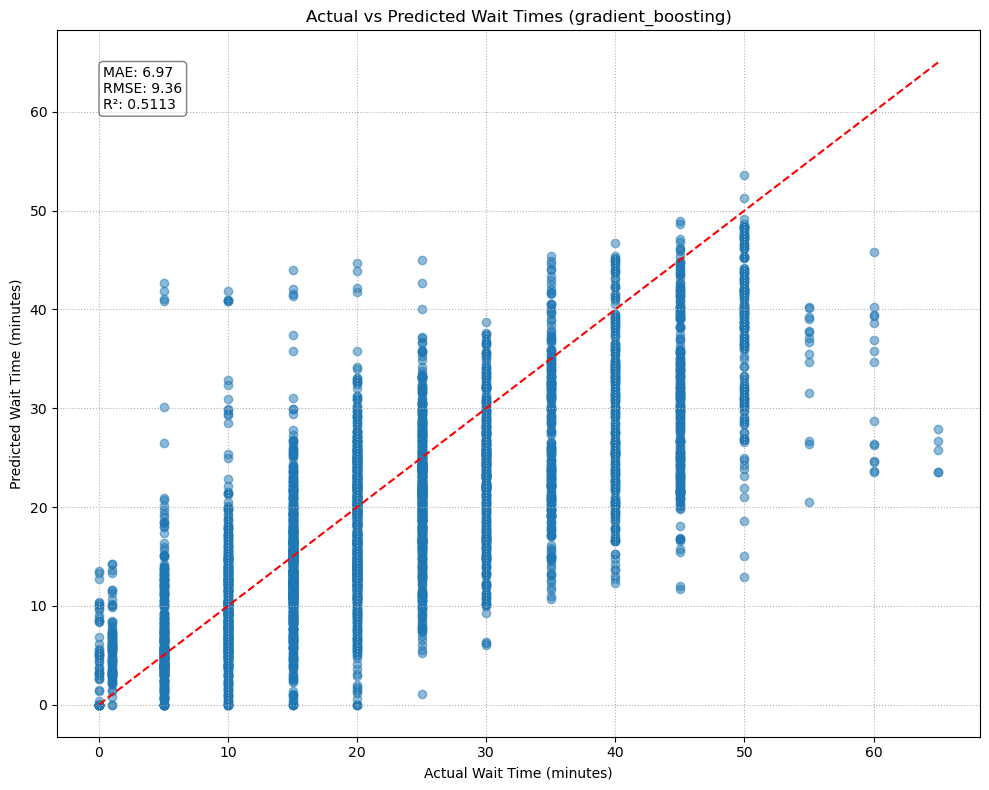

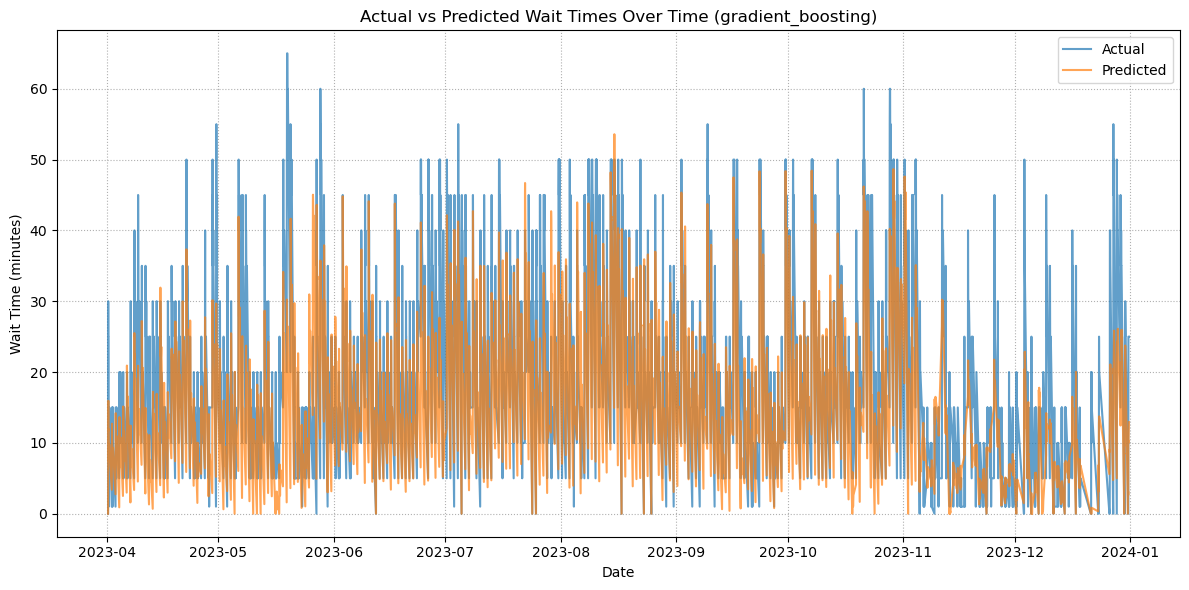

C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\2792618548.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\2792618548.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


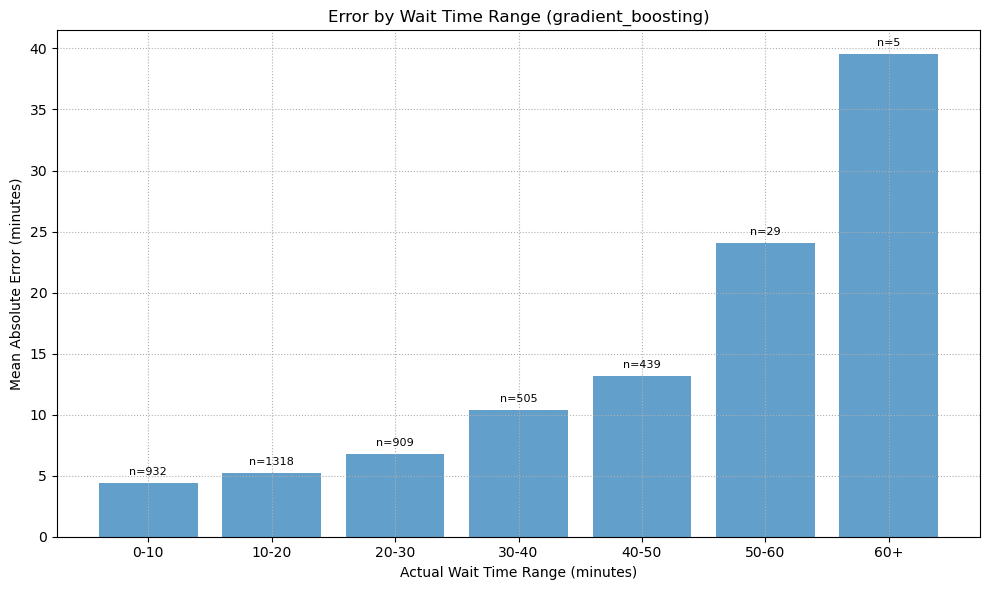


----- Saving models for silver star -----
Models saved to ../models

Successfully completed analysis for silver star


ANALYZING RIDE: POSEIDON

Number of fully closed days: 418
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 450
Sample of zero wait time days: Index([2017-06-06, 2017-08-31, 2017-09-12, 2017-09-13, 2017-09-14, 2017-09-19,
       2017-09-20, 2017-10-06, 2017-10-08, 2017-10-23],
      dtype='object', name='timestamp')
=== Training wait time prediction model (type: gradient_boosting) ===

----- Step 1: Creating all features -----

----- Step 2: Splitting data into train/test -----
Training data: 16808 samples
Test data: 2972 samples

----- Step 3: Training attendance prediction model -----
Converting date column to datetime...
Training attendance prediction model...
Training model f

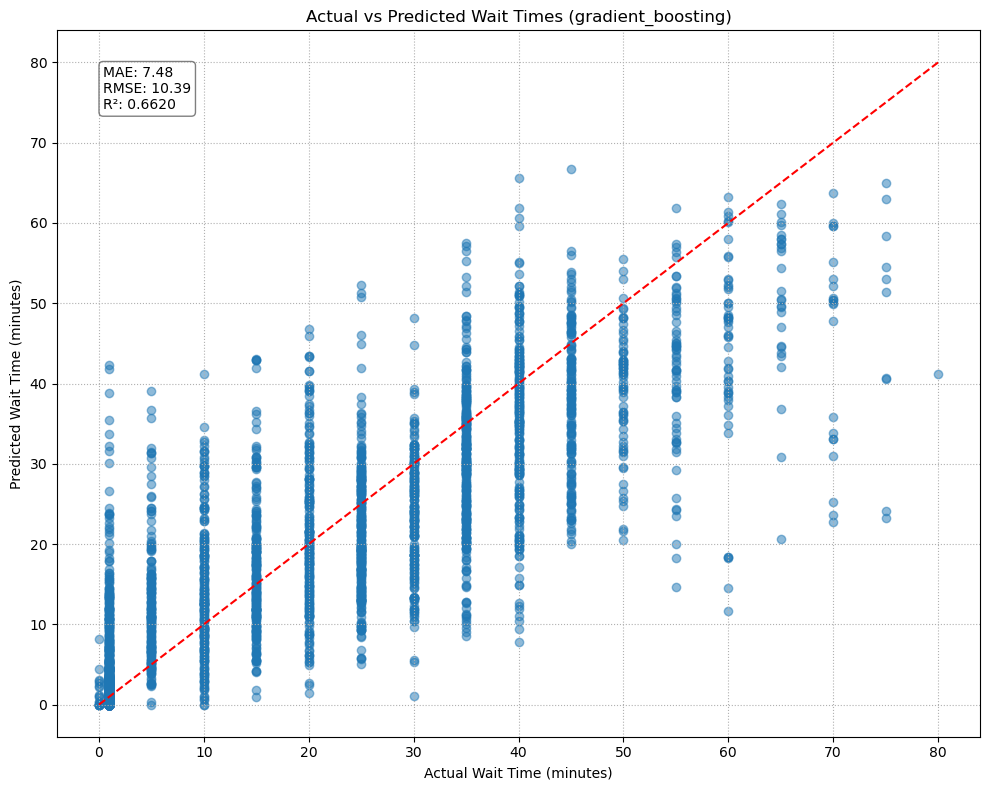

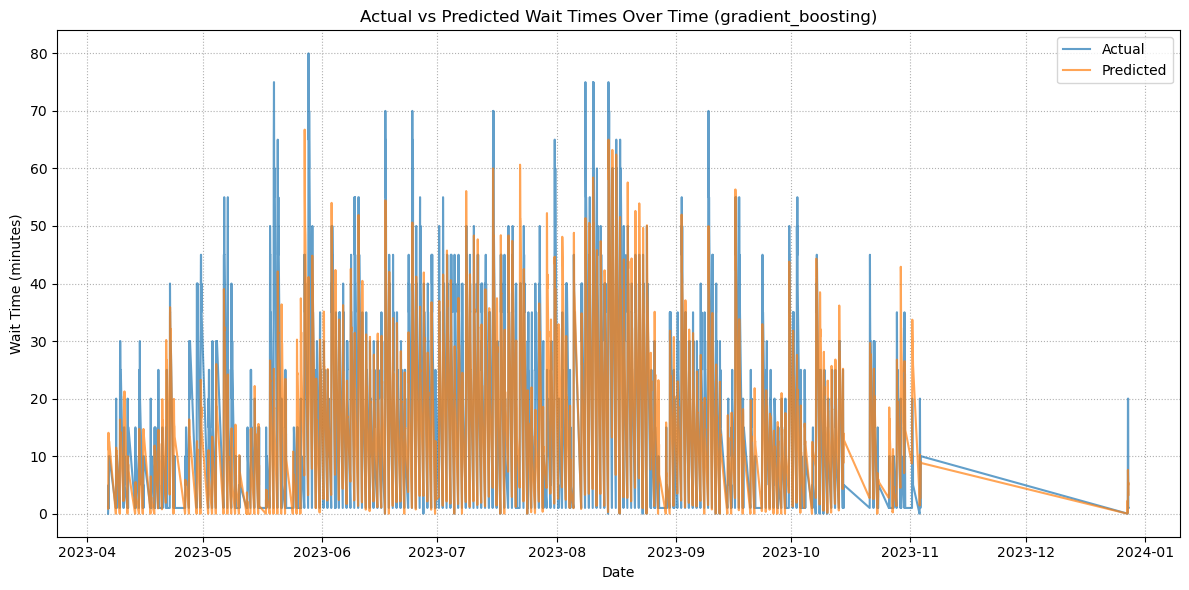

C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\2792618548.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics = results_df.groupby('wait_bin').agg({
C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\2792618548.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())


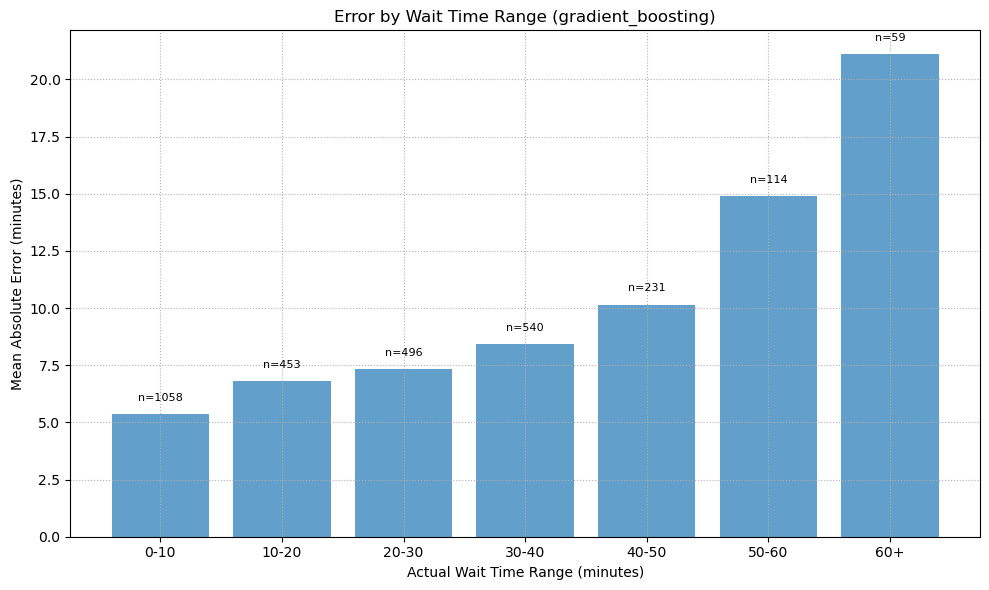


----- Saving models for poseidon -----
Models saved to ../models

Successfully completed analysis for poseidon


DEMONSTRATING FUTURE WAIT TIME PREDICTIONS
Future dates for prediction:
  - 2025-05-03
  - 2025-05-04
  - 2025-05-05
  - 2025-05-06
  - 2025-05-07
  - 2025-05-08
  - 2025-05-09
  - 2025-05-10

Predicting future wait times for silver star...
Attempting real prediction...
=== Predicting future wait times for silver star ===

----- Step 1: Loading historical data -----
Loaded historical data: 403100 samples

----- Step 2: Loading trained models -----
Loaded corrected gradient boosting model for silver star

----- Step 3: Generating features for future dates -----
Predicted attendance for 8 future dates
Error adding historical patterns: 'hour'
Adding default historical pattern values

----- Step 4: Ensuring all required features are present -----
Found 155 required features from model
Adding missing feature: is_german_holiday
Adding missing feature: is_swiss_holiday
Adding miss

C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\3373701453.py:302: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_df[feature] = 0  # Default no special event
C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\3373701453.py:302: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_df[feature] = 0  # Default no special event
C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\3373701453.py:302: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

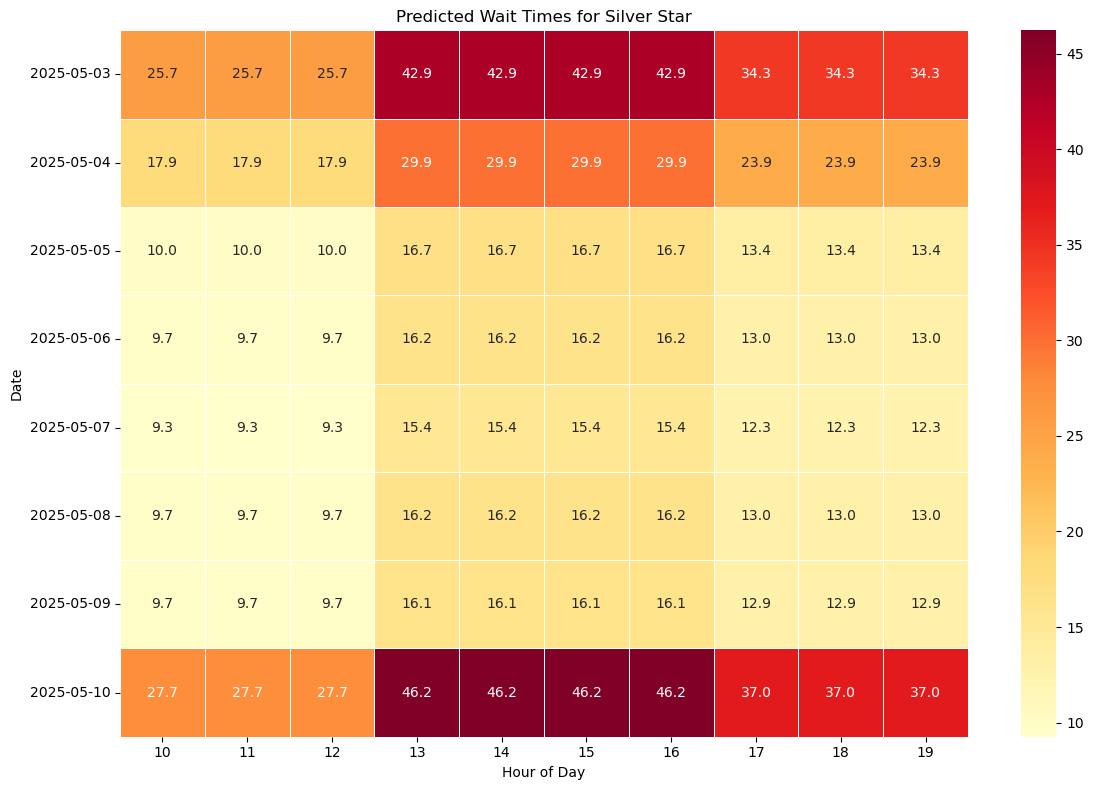


Predicting future wait times for poseidon...
Attempting real prediction...
=== Predicting future wait times for poseidon ===

----- Step 1: Loading historical data -----
Loaded historical data: 410698 samples

----- Step 2: Loading trained models -----
Loaded corrected gradient boosting model for poseidon

----- Step 3: Generating features for future dates -----
Predicted attendance for 8 future dates
Error adding historical patterns: 'hour'
Adding default historical pattern values

----- Step 4: Ensuring all required features are present -----
Found 155 required features from model
Adding missing feature: is_german_holiday
Adding missing feature: is_swiss_holiday
Adding missing feature: is_french_holiday
Adding missing feature: is_summer_vacation_2017
Adding missing feature: is_summer_vacation_2017_tomorrow
Adding missing feature: is_summer_vacation_2017_yesterday
Adding missing feature: is_spring_break_2017
Adding missing feature: is_spring_break_2017_tomorrow
Adding missing feature

C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\3373701453.py:302: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_df[feature] = 0  # Default no special event
C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\3373701453.py:302: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_df[feature] = 0  # Default no special event
C:\Users\Nevin\AppData\Local\Temp\ipykernel_10128\3373701453.py:302: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

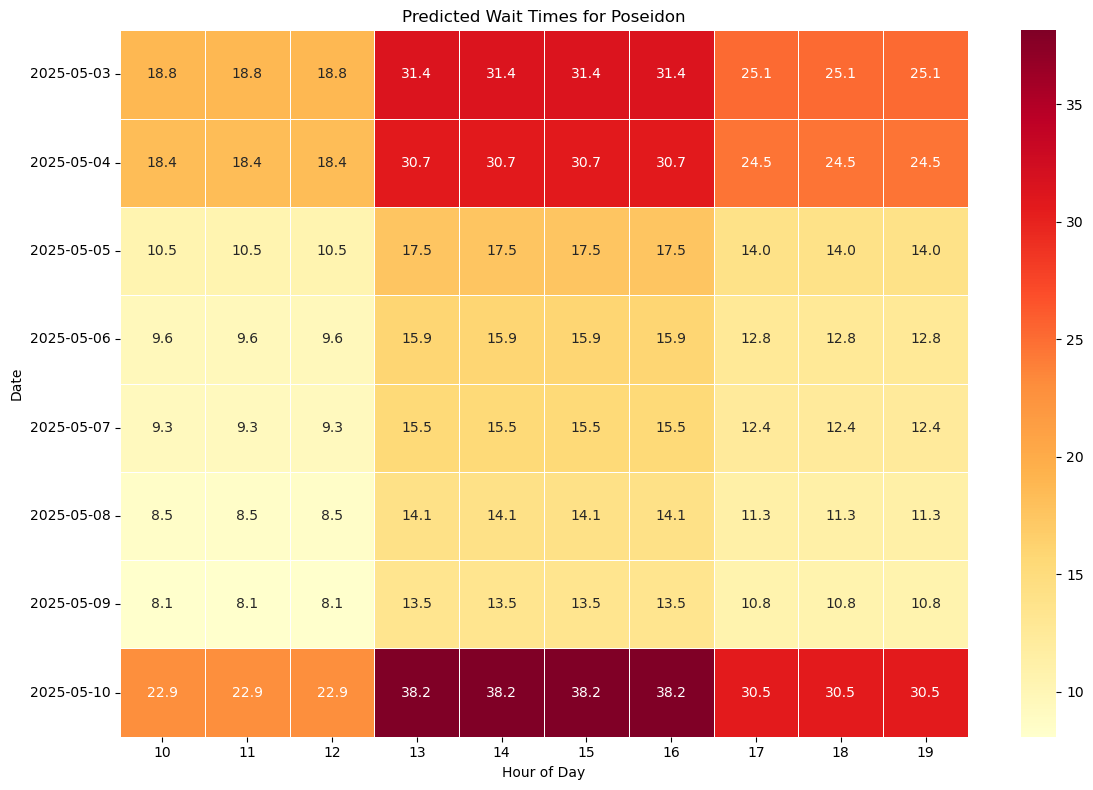

In [48]:
if __name__ == "__main__":
    main()